## Preprocessing
* Clip/scale & normalise
  * Voxel intensities is clipped to chosen percentiles (0.5-99.5% in this case) and rescaled to [0,1]
  * Prevents outliers from dominating contrast and ensures consistent data ranges across scans
* Anisotropic diffusion filter
  * Perona-Malik, applied voxel-wise over several iterations
  * Reduces high-frequency noise while preserving sharp intensity transitions
  * Helps keeping pore/active-material boundaries

In [39]:

from typing import Any, Dict, Literal, Tuple

import numpy as np
import scipy.ndimage as ndi
import tifffile as tiff
import matplotlib.pyplot as plt

def show_slices(v: np.ndarray, title: str = "") -> None:
    """Display axial, coronal, and sagittal slices of a 3D volume.

    Args:
        v: 3D numpy array representing the volume (z, y, x).
        title: Title for the plot.
    """
    z, y, x = v.shape
    fig, axs = plt.subplots(1,3, figsize=(10,3))
    axs[0].imshow(v[z//2], cmap="gray"); axs[0].set_title("Axial")
    axs[1].imshow(v[:,y//2,:], cmap="gray"); axs[1].set_title("Coronal")
    axs[2].imshow(v[:,:,x//2], cmap="gray"); axs[2].set_title("Sagittal")
    for a in axs: a.axis("off")
    fig.suptitle(title); plt.tight_layout(); plt.show()

def clip_and_scale(
    v: np.ndarray, pcts: Tuple[float, float] = (0.5, 99.5), eps: float = 1e-6
) -> Tuple[np.ndarray, float, float]:
    """Clip and scale a value to the range [0, 1] based on given percentiles.

    Args:
        v: The input value or array to be clipped and scaled.
        pcts: A tuple containing the lower and upper percentiles for clipping.
        eps: A small epsilon value to prevent division by zero.

    Returns:
        A list containing the clipped and scaled array,
        the lower percentile value, and the upper percentile value.
    """
    p1, p2 = np.percentile(v, pcts)

    if not np.isfinite(p1) or not np.isfinite(p2):
        raise ValueError("Percentiles are NaN/Inf")

    if p2 <= p1:
        scaled = np.zeros_like(v, dtype=np.float32)
        return scaled, float(p1), float(p2)
    else:
        clipped: np.ndarray = np.clip(v, p1, p2)
        scaled_v: np.ndarray = (clipped - p1) / (p2 - p1 + eps)
        scaled = scaled_v.astype(np.float32, copy=False)

    np.clip(scaled, 0.0, 1.0, out=scaled)
    return scaled, float(p1), float(p2)

def anisotropic_diffusion_2d(img, niter=10, kappa=20, gamma=0.1):
    img = img.astype(np.float32)

    for _ in range(niter):
        # gradients
        dN = np.zeros_like(img)
        dS = np.zeros_like(img)
        dE = np.zeros_like(img)
        dW = np.zeros_like(img)

        dN[:-1, :] = img[1:, :] - img[:-1, :]
        dS[1:, :]  = img[:-1, :] - img[1:, :]
        dE[:, :-1] = img[:, 1:] - img[:, :-1]
        dW[:, 1:]  = img[:, :-1] - img[:, 1:]

        # conduction
        cN = np.exp(-(dN/kappa)**2)
        cS = np.exp(-(dS/kappa)**2)
        cE = np.exp(-(dE/kappa)**2)
        cW = np.exp(-(dW/kappa)**2)

        # update
        img += gamma * (cN*dN + cS*dS + cE*dE + cW*dW)

    return img

    
def preprocess_stack(
    stack: np.ndarray,
    cfg: Dict[str, Any] = {},
) -> np.ndarray:
    """Preprocess the input stack based on the provided configuration.

    Args:
        stack: Input 3D numpy array representing the stack.
        cfg: Configuration dictionary specifying preprocessing steps.

    Returns:
        Preprocessed 3D numpy array.
    """
    # preprocessed_stack = stack.copy()
    # niter = cfg.get("ad_niter", 10)
    # kappa = cfg.get("ad_kappa", 20.0)
    # gamma = cfg.get("ad_gamma", 0.1)
    # option = cfg.get("ad_option", 1)
    # preprocessed_stack = anisotropic_diffusion_2d(
    #     preprocessed_stack,
    #     niter=niter,
    #     kappa=kappa,
    #     step=(1.0, 1.0, 1.0),
    #     gamma=gamma,
    #     option=option,
    # )
    # print(
    #     f"Applied Anisotropic Diffusion with niter={niter}, kappa={kappa}, gamma={gamma}, option={option}."
    # )

    # return preprocessed_stack
    
    with tiff.TiffFile("../data/LG_MJ1_18650.tif") as tif:
        pages = tif.pages
        Z = len(pages)
        Y, X = pages[0].shape

        # prepare output files (bigtiff)
        out = tiff.TiffWriter("filtered.tif", bigtiff=True)

        for z in range(Z):
            slice_z = pages[z].asarray()
            slice_f = anisotropic_diffusion_2d(slice_z)
            
            out.write(slice_f, photometric="minisblack")

    out.close()


preprocessed_stack = preprocess_stack()

# show_slices(raw_data, title="Raw Volume")
# show_slices(preprocessed_stack, title="Preprocessed Volume")

KeyboardInterrupt: 

## Auto-seeding
* Distinguishes 3 different classes within the 3D volume
  * Certain foreground
  * Foreground nuance 1 (less certain, lower intensity)
  * Foreground nuance 2 (more certain, higher intensity)

In [31]:
from skimage.filters import threshold_multiotsu, threshold_otsu
from skimage.morphology import ball
def multi_otsu_3d(
    volume: np.ndarray,
    classes: int = 3,
    min_bg_size: int = 5000,
    max_bg_size: int = 200000,
) -> Tuple[Any, Any, float | int]:
    """
    3D multi-Otsu segmentation with background exclusion.
    Returns thresholds, labeled volume, and interclass variance.
    """
    v = volume.astype(np.float32, copy=False)

    # Detect background using Otsu threshold
    try:
        otsu_threshold = threshold_otsu(v)
        background_threshold = otsu_threshold * 0.3
    except Exception:
        background_threshold = np.percentile(v, 2)

    # Create background mask from largest low-intensity region
    low_intensity_mask = v < background_threshold

    if np.any(low_intensity_mask):
        labeled_mask, num_features = ndi.label(low_intensity_mask)

        if num_features > 0:
            component_sizes = np.bincount(labeled_mask.ravel())
            if len(component_sizes) > 1:
                largest_component = np.argmax(component_sizes[1:]) + 1
                background_mask = labeled_mask == largest_component

                # Apply size constraints to background region
                region_size = component_sizes[largest_component]
                if min_bg_size <= region_size <= max_bg_size:
                    background_mask = ndi.binary_dilation(
                        background_mask, structure=ball(1)
                    )
                else:
                    background_mask = low_intensity_mask
            else:
                background_mask = low_intensity_mask
        else:
            background_mask = low_intensity_mask
    else:
        background_mask = np.zeros_like(v, dtype=bool)

    # Segment only foreground regions
    foreground_mask = ~background_mask
    foreground_data = v[foreground_mask]

    if foreground_data.size == 0:
        return np.array([]), np.zeros_like(v, dtype=np.uint8), float("nan")

    # Apply multi-Otsu to foreground
    thresholds = threshold_multiotsu(foreground_data, classes=classes)

    # Label the volume (0 = background, 1..classes = foreground classes)
    labeled_volume = np.zeros_like(v, dtype=np.uint8)

    if foreground_data.size == 0:
        # nothing to segment; return empty foreground and NaN variance
        return np.array([]), labeled_volume, float("nan")

    t = thresholds  # len = classes-1

    # First foreground class
    labeled_volume[foreground_mask & (v <= t[0])] = 1

    # Middle classes (if any)
    for i in range(1, len(t)):
        mask = foreground_mask & (v > t[i - 1]) & (v <= t[i])
        labeled_volume[mask] = i + 1

    # Last foreground class
    labeled_volume[foreground_mask & (v > t[-1])] = classes

    # Interclass variance over foreground classes (background=0 is excluded)
    N_fg = int(foreground_mask.sum())
    if N_fg == 0:
        interclass_variance = float("nan")
    else:
        global_mean = float(v[foreground_mask].mean())

        class_means = []
        class_weights = []
        for c in range(1, classes + 1):  # foreground classes only
            cmask = labeled_volume == c
            n = int(cmask.sum())
            if n == 0:
                continue
            class_means.append(float(v[cmask].mean()))
            class_weights.append(n / N_fg)

        interclass_variance = sum(
            w * (m - global_mean) ** 2 for w, m in zip(class_weights, class_means)
        )

    return thresholds, labeled_volume, interclass_variance

thresholds, labeled_volume, icv = multi_otsu_3d(
    raw_data,
    classes=2,
    min_bg_size=5000,
    max_bg_size=200000,
)

print("Interclass Variance:", icv)

MemoryError: Unable to allocate 7.63 GiB for an array with shape (1782, 1124, 1022) and data type float32

## Binarise with region growing

* Split grayscale volume into three intensity bands
* Adaptive selection of q_tail
  * Ensures that roughly 15% of each band is used as sure seeds, even when the bands are narrow or noisy
  * Falls back to a default if there aren't enough voxels to estimate reliably
* Seed propagation

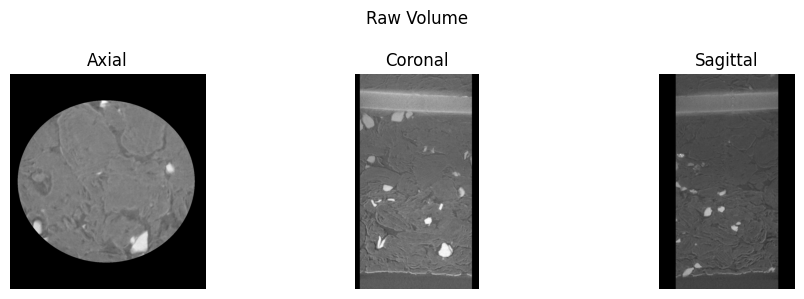

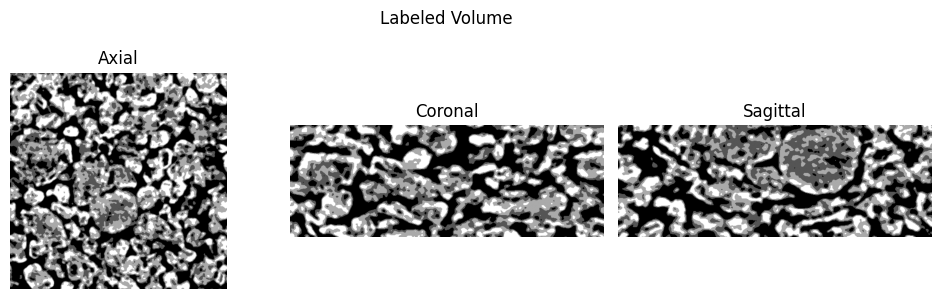

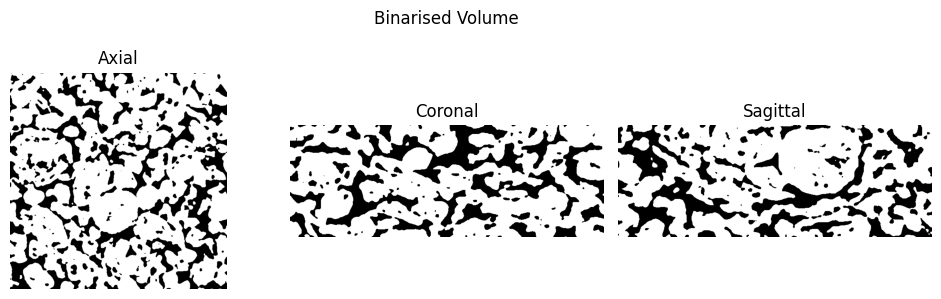

In [29]:
def _estimate_q_tail(
    dark_band: np.ndarray, bright_band: np.ndarray, target_seed_fraction: float = 0.15
) -> float:
    """Adaptively set q_tail to get ~15% of each band as seeds
    Handles cases where bands are narrow or wide

    Args:
        dark_band: Voxels in the dark band.
        bright_band: Voxels in the bright band.
        target_seed_fraction: Target fraction of voxels to be selected as seeds.

    Returns:
        Estimated q_tail value.
    """
    dark_std = np.std(dark_band)
    bright_std = np.std(bright_band)

    avg_std = 0.5 * (dark_std + bright_std)
    q_tail = np.clip(0.3 * (avg_std / 0.1), 0.1, 0.4)
    return q_tail


def binarise(
    volume: np.ndarray,
    t1: float,
    t2: float,
    foreground_mask: np.ndarray | None = None,
    q_tail: float | None = None,
    connectivity: int = 1,
    debug: bool = False,
) -> np.ndarray:
    v = volume.astype(np.float32, copy=False)
    if foreground_mask is None:
        foreground_mask = np.ones(v.shape, bool)

    # ---- bands ----
    dark = (v < t1) & foreground_mask
    mid = (v >= t1) & (v < t2) & foreground_mask
    bright = (v >= t2) & foreground_mask

    if q_tail is None:
        if dark.any() and bright.any():
            q_tail = _estimate_q_tail(v[dark], v[bright])
            if debug:
                print(f"Auto-estimated q_tail: {q_tail:.3f}")
        else:
            q_tail = 0.30  # Fallback default
            if debug:
                print(f"Using default q_tail: {q_tail:.3f} (insufficient data)")

    if debug:
        print(
            {
                "frac_dark": float(dark.mean()),
                "frac_mid": float(mid.mean()),
                "frac_bright": float(bright.mean()),
                "t1": float(t1),
                "t2": float(t2),
            }
        )

    # ---- strong seeds (tails) ----
    if dark.any():
        bg_cut = np.quantile(v[dark], q_tail)
    else:
        bg_cut = t1
    sure_bg = (v <= bg_cut) & foreground_mask

    if bright.any():
        fg_cut = np.quantile(v[bright], 1 - q_tail)
    else:
        fg_cut = t2
    sure_fg = (v >= fg_cut) & foreground_mask

    if debug:
        print(
            {
                "bg_cut": float(bg_cut),
                "fg_cut": float(fg_cut),
                "sure_bg_voxels": int(sure_bg.sum()),
                "sure_fg_voxels": int(sure_fg.sum()),
            }
        )

    # ---- allowed regions for growth ----
    bg_allowed = dark | mid
    fg_allowed = bright | mid

    # ---- propagate ----
    S = ndi.generate_binary_structure(3, min(connectivity, 3))
    bg_grown = ndi.binary_propagation(input=sure_bg, mask=bg_allowed, structure=S)
    fg_grown = ndi.binary_propagation(input=sure_fg, mask=fg_allowed, structure=S)

    if debug:
        print(
            {
                "bg_grown": int(bg_grown.sum()),
                "fg_grown": int(fg_grown.sum()),
                "allowed_bg_voxels": int(bg_allowed.sum()),
                "allowed_fg_voxels": int(fg_allowed.sum()),
            }
        )

    # ---- resolve overlaps ----
    both = bg_grown & fg_grown
    if both.any():
        dist_bg = np.abs(v[both] - t1)
        dist_fg = np.abs(v[both] - t2)
        choose_fg = dist_fg < dist_bg
        idx = np.where(both)
        fg_grown = fg_grown.copy()
        fg_grown[idx[0][choose_fg], idx[1][choose_fg], idx[2][choose_fg]] = True
        bg_grown[idx[0][~choose_fg], idx[1][~choose_fg], idx[2][~choose_fg]] = True

    # ---- build binary ----
    bin_mask = np.zeros_like(v, np.uint8)
    bin_mask[bg_grown] = 0
    bin_mask[fg_grown] = 1

    leftover = foreground_mask & ~(bg_grown | fg_grown)
    if leftover.any():
        bin_mask[leftover & (v >= 0.5 * (t1 + t2))] = 1

    if debug:
        labeled, ncomp = ndi.label(
            bin_mask, structure=ndi.generate_binary_structure(3, 1)
        )
        counts = np.bincount(labeled.ravel())
        largest = int(counts[1:].max()) if counts.size > 1 else 0
        fg_frac = float(bin_mask.mean())
        largest_frac = largest / bin_mask.size
        mid_claim_fg = (bin_mask.astype(bool) & mid).sum() / max(1, mid.sum())

        print(
            {
                "fg_frac": fg_frac,
                "n_components": int(ncomp),
                "largest_frac": largest_frac,
                "mid_claim_fg": float(mid_claim_fg),
            }
        )

    return bin_mask

binarised_volume = binarise(
    labeled_volume,
    t1=thresholds[0],
    t2=thresholds[1],
)

show_slices(raw_data, title="Raw Volume")
show_slices(labeled_volume, title="Labeled Volume")
show_slices(binarised_volume, title="Binarised Volume")


## Post-processing
* Morphological operations
  * 3D connectivity-1 structuring element
  * Binary closing to seal small gaps, cracks, and pinholes within particles or along grain boundaries
  * Binary opening to remove isolated noise voxels and thin spurious structures while preserving overall particle shape
  * Radius parameter controls the number of iterations
* Fill internal pores/holes
  * Fill fully enclosed voids inside the segmented phase
  * Yields a soldi representation of the active material

Postprocessing mask...


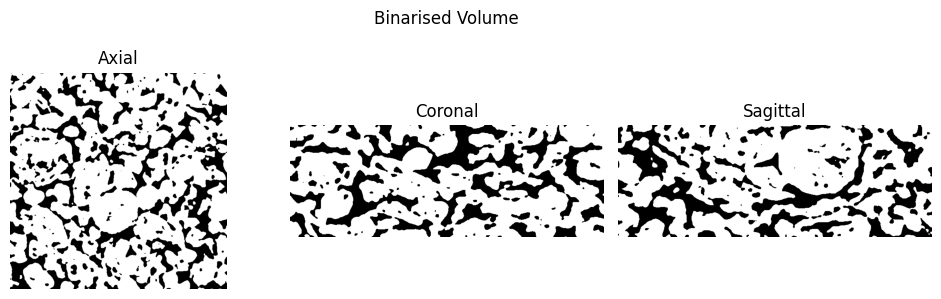

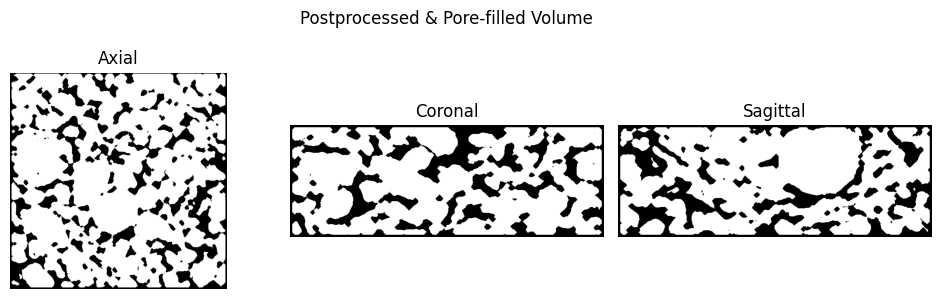

In [26]:
import numpy as np
from scipy.ndimage import (
    binary_closing,
    binary_fill_holes,
    binary_opening,
    generate_binary_structure,
)

def postprocess_mask(mask: np.ndarray, radius: int = 1) -> np.ndarray:
    """Postprocess a binary mask using morphological operations.

    Args:
        mask (np.ndarray): Input binary mask.
        Radius (int, optional): Number of iterations for morphological operations. Defaults to 1.

    Returns:
        np.ndarray: Postprocessed binary mask.
    """
    print("Postprocessing mask...")
    # Ensure mask is binary
    bin_mask = (mask > 0).astype(bool)

    structure = generate_binary_structure(rank=3, connectivity=1)

    closed = binary_closing(bin_mask, structure=structure, iterations=radius)
    opened = binary_opening(closed, structure=structure, iterations=radius)

    return opened.astype(np.uint8)


def fill_internal_pores(mask: np.ndarray) -> np.ndarray:
    """Fill pores using ndimage binary_fill_holes

    Args:
        mask (np.ndarray): Input binary mask

    Returns:
        np.ndarray: Postprocessed binary mask
    """
    bin_mask = (mask > 0).astype(bool)
    filled = binary_fill_holes(bin_mask)
    return filled.astype(np.uint8)


morphologically_postprocessed = postprocess_mask(binarised_volume, radius=1)
pore_filled = fill_internal_pores(morphologically_postprocessed)

show_slices(binarised_volume, title="Binarised Volume")
show_slices(pore_filled, title="Postprocessed & Pore-filled Volume")

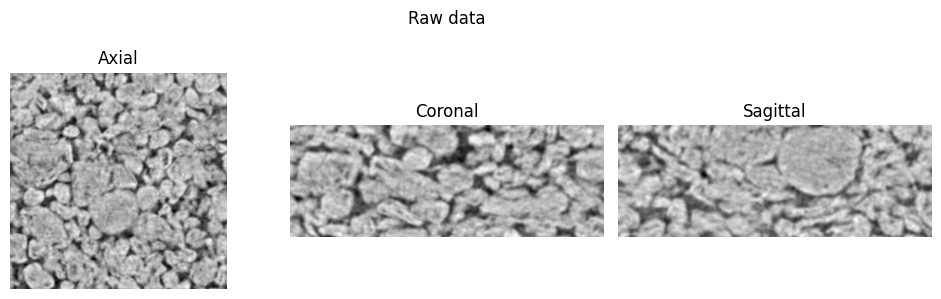

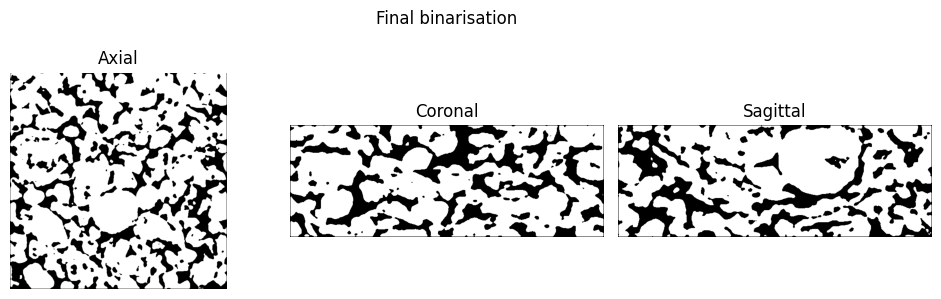

In [21]:
show_slices(raw_data, "Raw data")
show_slices(pore_filled, "Final binarisation")